In [10]:
from tsai.all import *
my_setup()

os              : Linux-6.5.0-14-generic-x86_64-with-glibc2.38
python          : 3.11.5
tsai            : 0.3.9
fastai          : 2.7.14
fastcore        : 1.5.29
torch           : 2.2.0+cu121
device          : cpu
cpu cores       : 4
threads per cpu : 2
RAM             : 15.32 GB
GPU memory      : N/A


In [16]:
from giza_datasets import *
import polars
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df : polars.DataFrame = DatasetsLoader().load('tokens-daily-prices-mcap-volume')

In [6]:
data: pd.DataFrame = df.to_pandas()
data = data[data['token']=='ETH']
data = data.drop(columns=['token'])
#df["date"] = pd.to_datetime(df["date"], unit="ms")
data['date'] = pd.to_datetime(data['date'])
data['date_epoch'] = pd.DatetimeIndex(data['date']).astype(np.int64) // 1e3
#df.set_index("date", inplace=True)

In [7]:
data.head()

,date,price,market_cap,volumes_last_24h,date_epoch
16233,2015-08-07,2.831620,0.000000e+00,9.062200e+04,1.438906e+09
16234,2015-08-08,1.330750,8.033948e+07,3.680700e+05,1.438992e+09
16235,2015-08-10,0.687586,4.155631e+07,4.004641e+05,1.439165e+09
16236,2015-08-11,1.067379,6.453901e+07,1.518998e+06,1.439251e+09
16237,2015-08-12,1.256613,7.601326e+07,2.073893e+06,1.439338e+09


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [9]:
# Forecast difference of log values
X, Y = data[['date_epoch']], data['price']
#X, Y = data[['date_epoch']], data['price']
print (X.head(), Y.head())

         date_epoch
16233  1.438906e+09
16234  1.438992e+09
16235  1.439165e+09
16236  1.439251e+09
16237  1.439338e+09 16233    2.831620
16234    1.330750
16235    0.687586
16236    1.067379
16237    1.256613
Name: price, dtype: float64


In [10]:
# Split in train-test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, shuffle=False, random_state=0)

X.head

<bound method NDFrame.head of          date_epoch
16233  1.438906e+09
16234  1.438992e+09
16235  1.439165e+09
16236  1.439251e+09
16237  1.439338e+09
...             ...
19332  1.706746e+09
19333  1.706832e+09
19334  1.706918e+09
19335  1.707005e+09
19336  1.707091e+09

[3104 rows x 1 columns]>

In [11]:
# Initialize the estimator
model = RandomForestRegressor()

In [12]:
# Fit the data
model.fit(X_train, Y_train)

RandomForestRegressor()

In [17]:
# Make predictions
pred = model.predict(X_test)

In [18]:
def to_datetime_from_epoch(x):
    return datetime.datetime.fromtimestamp(x)

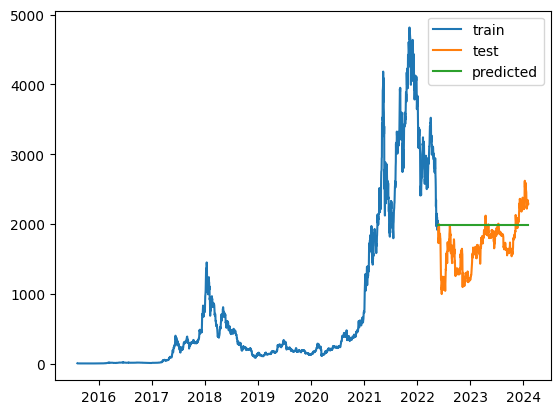

In [19]:
fig,ax = plt.subplots()
ax.plot([to_datetime_from_epoch(x) for x in X_train['date_epoch']],Y_train,label='train')
ax.plot([to_datetime_from_epoch(x) for x in X_test['date_epoch']],Y_test,label='test')
ax.plot([to_datetime_from_epoch(x) for x in X_test['date_epoch']],pred,label='predicted')
plt.legend()

In [185]:
# Export to ONNX

In [207]:
from sklearn.datasets import load_iris
from skl2onnx import to_onnx, convert_sklearn
from skl2onnx.common.data_types import FloatTensorType, Int64TensorType

In [209]:
# 'date_epoch','market_cap','volumes_last_24h
initial_types = [
    ('floats', FloatTensorType([None, 3])),
]
#to_onnx(model, )
#convert_sklearn(model, initial_types=initial_types)
onx = to_onnx(model, initial_types=initial_types)
with open("rf_giza.onnx", "wb") as f:
    f.write(onx.SerializeToString())

In [210]:
# Create Sierra file